In [1]:
#importing required modules 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import random
import os

from pyspark.sql import SparkSession 

In [2]:
# loading dataset 
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

23/06/06 23:41:28 WARN Utils: Your hostname, Johns-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.25 instead (on interface en0)
23/06/06 23:41:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/06 23:41:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load the dataset and create sprk dataframe

sql_df = spark.read.csv('../JC_Project_4_working/Loan_Train.csv', sep=",", inferSchema=True,header=True)

# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table

sql_df.limit(5).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,Y


In [4]:
sql_df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [5]:
sql_df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



***For visualization, converting PySpark Dataframe to Pandas DataFrame***

In [6]:
#from spark.sql df to Panadas df

data = sql_df.toPandas()

In [7]:
# Describing data
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
#check datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int32  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int32(1), object(8)
memory usage: 60.1+ KB


In [47]:
# Calculate outliers for LoanAmount column
Q1_loan = data['LoanAmount'].quantile(0.25)
Q3_loan = data['LoanAmount'].quantile(0.75)
IQR_loan = Q3_loan - Q1_loan

lower_bound_loan = Q1_loan - (1.5 * IQR_loan)
upper_bound_loan = Q3_loan + (1.5 * IQR_loan)

# Filter outliers for LoanAmount column
outliers_loan = data[(data['LoanAmount'] < lower_bound_loan) | (data['LoanAmount'] > upper_bound_loan)]

# Calculate outliers for ApplicantIncome column
Q1_income = data['ApplicantIncome'].quantile(0.25)
Q3_income = data['ApplicantIncome'].quantile(0.75)
IQR_income = Q3_income - Q1_income

lower_bound_income = Q1_income - (1.5 * IQR_income)
upper_bound_income = Q3_income + (1.5 * IQR_income)

# Filter outliers for ApplicantIncome column
outliers_income = data[(data['ApplicantIncome'] < lower_bound_income) | (data['ApplicantIncome'] > upper_bound_income)]

# Create filtered DataFrame without outliers
filtered_data_df = data[~(data['LoanAmount'].isin(outliers_loan['LoanAmount']) | data['ApplicantIncome'].isin(outliers_income['ApplicantIncome']))]



In [45]:
filtered_data_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,547.000000,547.000000,527.000000,533.000000,502.000000
mean,4047.550274,1537.052870,127.396584,342.101313,0.840637
std,1855.553192,2380.417249,46.334010,65.971721,0.366379
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2719.000000,0.000000,99.000000,360.000000,1.000000
50%,3597.000000,1330.000000,122.000000,360.000000,1.000000
75%,4906.000000,2264.500000,155.000000,360.000000,1.000000
max,10139.000000,33837.000000,267.000000,480.000000,1.000000


In [25]:
Q1 = data['LoanAmount'].quantile(0.25)
Q3 = data['LoanAmount'].quantile(0.75)
IQR = Q3 - Q1

IQR
Q1
Q3
print(f'''
      IQR is {IQR}
      Q1 is {Q1}
      Q3 is {Q3} ''')



lower_bound2 = Q1 - (1.5 * IQR)
upper_bound2 = Q3 + (1.5 * IQR)
outliers2 =data[(data['LoanAmount'] < lower_bound) | (data['LoanAmount'] > upper_bound)]


      IQR is 68.0
      Q1 is 100.0
      Q3 is 168.0 


In [29]:
lower_bound2 = Q1 - (1.5 * IQR)
upper_bound2 = Q3 + (1.5 * IQR)
outliers2 =data[(data['LoanAmount'] < lower_bound2) | (data['LoanAmount'] > upper_bound2)]

In [30]:
print(f'''
Lower_bound : {lower_bound2}
Upper_bound : {upper_bound2}
Outliers : {outliers2}

''')


Lower_bound : -2.0
Upper_bound : 270.0
Outliers :       Loan_ID  Gender Married Dependents     Education Self_Employed  \
9    LP001020    Male     Yes          1      Graduate            No   
21   LP001046    Male     Yes          1      Graduate            No   
34   LP001100    Male      No         3+      Graduate            No   
54   LP001186  Female     Yes          1      Graduate           Yes   
67   LP001233    Male     Yes          1      Graduate            No   
126  LP001448    None     Yes         3+      Graduate            No   
130  LP001469    Male      No          0      Graduate           Yes   
135  LP001488    Male     Yes         3+      Graduate            No   
155  LP001536    Male     Yes         3+      Graduate            No   
161  LP001562    Male     Yes          0      Graduate            No   
171  LP001585    None     Yes         3+      Graduate            No   
177  LP001610    Male     Yes         3+      Graduate            No   
233  LP001776

In [31]:
len(outliers2)

39

In [9]:
# checking for outliers 
Q1 = data['ApplicantIncome'].quantile(0.25)
Q3 = data['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1


In [10]:
IQR
Q1
Q3
print(f'''
      IQR is {IQR}
      Q1 is {Q1}
      Q3 is {Q3} ''')


      IQR is 2917.5
      Q1 is 2877.5
      Q3 is 5795.0 
23/06/06 23:41:43 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [11]:
Q1

2877.5

In [12]:
Q3

5795.0

In [13]:
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
outliers =data[(data['ApplicantIncome'] < lower_bound) | (data['ApplicantIncome'] > upper_bound)]


In [14]:
print(f'''
Lower_bound : {lower_bound}
Upper_bound : {upper_bound}
Outliers : {outliers}

''')


Lower_bound : -1498.75
Upper_bound : 10171.25
Outliers :       Loan_ID  Gender Married Dependents     Education Self_Employed  \
9    LP001020    Male     Yes          1      Graduate            No   
34   LP001100    Male      No         3+      Graduate            No   
54   LP001186  Female     Yes          1      Graduate           Yes   
67   LP001233    Male     Yes          1      Graduate            No   
102  LP001350    Male     Yes       None      Graduate            No   
106  LP001369    Male     Yes          2      Graduate            No   
115  LP001401    Male     Yes          1      Graduate            No   
119  LP001422  Female      No          0      Graduate            No   
126  LP001448    None     Yes         3+      Graduate            No   
128  LP001451    Male     Yes          1      Graduate           Yes   
130  LP001469    Male      No          0      Graduate           Yes   
138  LP001492    Male      No          0      Graduate            No   
144  L

In [15]:
len(outliers)

50

In [16]:
outliers_df = pd.DataFrame(outliers)

In [17]:
outliers_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,50.000000,50.000000,48.000000,50.000000,47.000000
mean,19827.600000,819.820000,289.208333,343.200000,0.851064
std,13895.963281,2104.538339,170.703795,58.184787,0.359875
min,10408.000000,0.000000,40.000000,180.000000,0.000000
25%,12125.000000,0.000000,158.000000,360.000000,1.000000
50%,15379.500000,0.000000,259.500000,360.000000,1.000000
75%,19668.500000,0.000000,401.250000,360.000000,1.000000
max,81000.000000,10968.000000,700.000000,480.000000,1.000000


In [21]:
outliers_df.sort_values('LoanAmount', ascending=False)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
171,LP001585,None,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
130,LP001469,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,NaN,Urban,Y
561,LP002813,Female,Yes,1,Graduate,Yes,19484,0.0,600.0,360.0,1.0,Semiurban,Y
155,LP001536,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
369,LP002191,Male,Yes,0,Graduate,No,19730,5266.0,570.0,360.0,1.0,Rural,N
487,LP002547,Male,Yes,1,Graduate,No,18333,0.0,500.0,360.0,1.0,Urban,N
604,LP002959,Female,Yes,1,Graduate,No,12000,0.0,496.0,360.0,1.0,Semiurban,Y
333,LP002101,Male,Yes,0,Graduate,None,63337,0.0,490.0,180.0,1.0,Urban,Y
506,LP002624,Male,Yes,0,Graduate,No,20833,6667.0,480.0,360.0,NaN,Urban,Y
308,LP001996,Male,No,0,Graduate,No,20233,0.0,480.0,360.0,1.0,Rural,N


In [19]:
outliers['LoanAmount'].mean()

289.2083333333333

In [32]:
filtered_data =data.loc[(data['ApplicantIncome'] > lower_bound) & (data['ApplicantIncome'] < upper_bound)]

In [33]:
filtered_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,564.000000,564.000000,544.00000,550.000000,517.000000
mean,4124.723404,1692.294184,133.81250,341.890909,0.841393
std,1926.989806,2979.232330,59.06735,65.761526,0.365663
min,150.000000,0.000000,9.00000,12.000000,0.000000
25%,2744.000000,0.000000,100.00000,360.000000,1.000000
50%,3638.500000,1405.500000,124.00000,360.000000,1.000000
75%,5010.500000,2337.000000,159.25000,360.000000,1.000000
max,10139.000000,41667.000000,495.00000,480.000000,1.000000


In [10]:
data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [9]:
# Dropping Loan_ID column
data.drop(['Loan_ID'],axis=1,inplace=True)

## Filling NULL values 

In [10]:
#check null values
data.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [11]:
# Check the number of null values in each row
null_rows = data.isnull().sum(axis=1)

# Count the number of rows with null values
num_null_rows = null_rows[null_rows > 0].count()

# Display the count
print("Number of rows with null values:", num_null_rows)

Number of rows with null values: 134


In [12]:
#filling null values-- filling in null values with mode or mean values of the data. So if gender has more male than female, then we will fill Null values with Male. 

data.Gender.fillna(data['Gender'].mode()[0], inplace=True)

data.Married.fillna(data['Married'].mode()[0], inplace=True)

data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)


data.Self_Employed.fillna(data['Self_Employed'].mode()[0], inplace=True)

data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True) # Mean



data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace=True)

data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True) # Mode



In [13]:
#now check again null values
data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Exploratory Data Analysis

Number of people who take loan as group by Gender
Male      502
Female    112
Name: Gender, dtype: int64


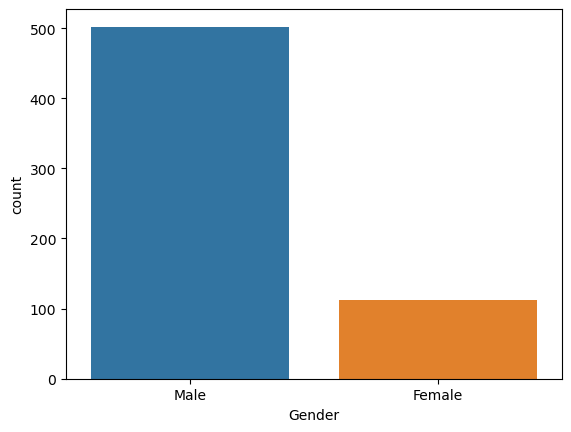

In [14]:
print("Number of people who take loan as group by Gender")
print(data['Gender'].value_counts())
sns.countplot(x="Gender",data=data)
plt.show()

Number of people who take loan as group by marital Status
Yes    401
No     213
Name: Married, dtype: int64


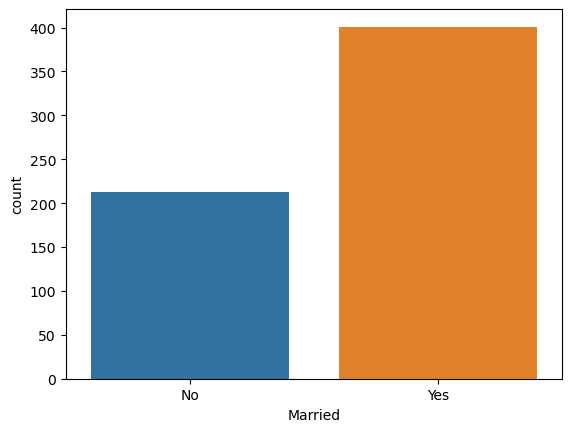

In [15]:
print("Number of people who take loan as group by marital Status")
print(data['Married'].value_counts())
sns.countplot(x="Married",data=data)
plt.show()

Number of people who take loan as group by Dependents
0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64


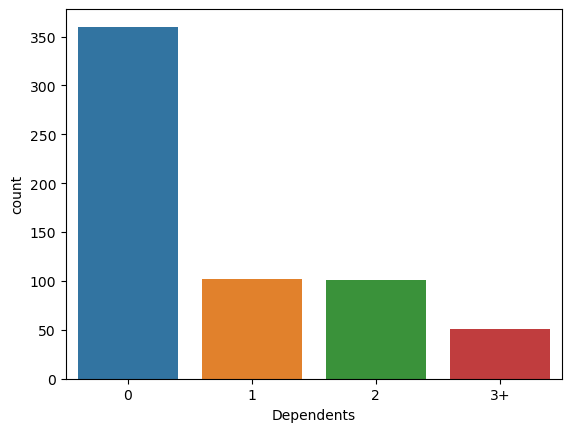

In [16]:
print("Number of people who take loan as group by Dependents")
print(data['Dependents'].value_counts())
sns.countplot(x="Dependents",data=data)
plt.show()

Number of people who take loan as group by Self_Employed
No     532
Yes     82
Name: Self_Employed, dtype: int64


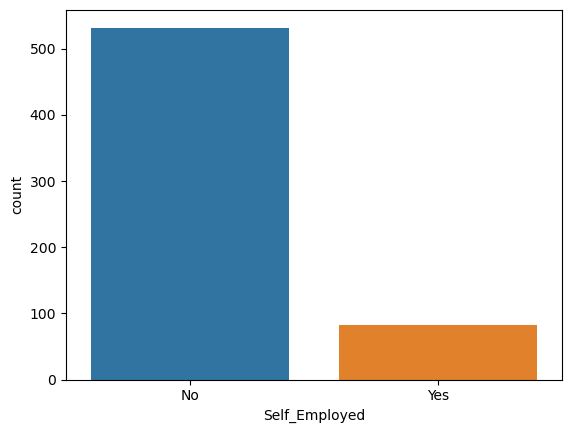

In [17]:
print("Number of people who take loan as group by Self_Employed")
print(data['Self_Employed'].value_counts())
sns.countplot(x="Self_Employed",data=data)
plt.show()

Number of people who take loan as group by Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


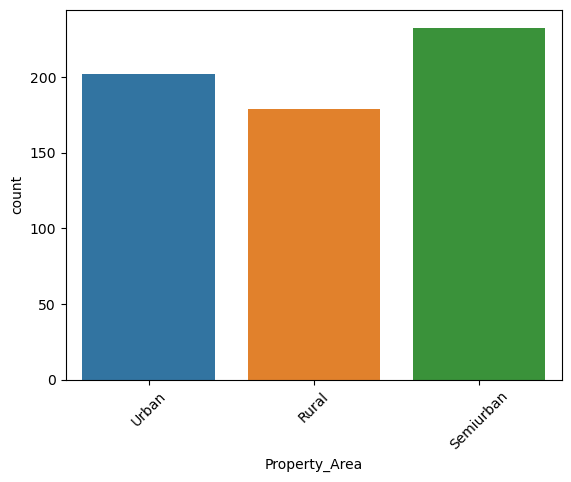

In [18]:
print("Number of people who take loan as group by Property_Area")
print(data['Property_Area'].value_counts())
sns.countplot(x="Property_Area",data=data)
plt.xticks(rotation=45)
plt.show()

Number of people who take loan as group by Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


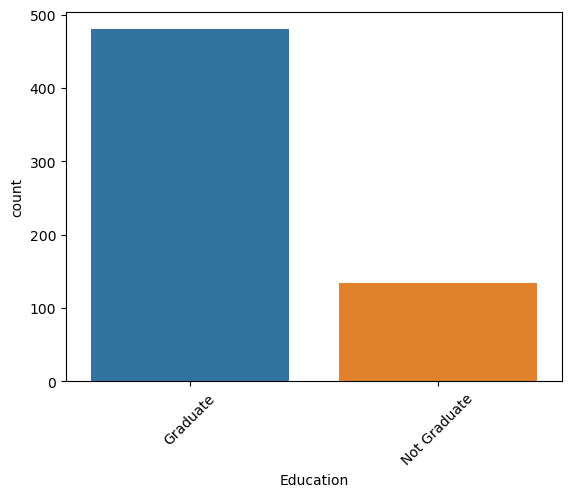

In [19]:
print("Number of people who take loan as group by Education")
print(data['Education'].value_counts())
sns.countplot(x="Education",data=data)
plt.xticks(rotation=45)
plt.show()

Number of people who take loan as group by Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


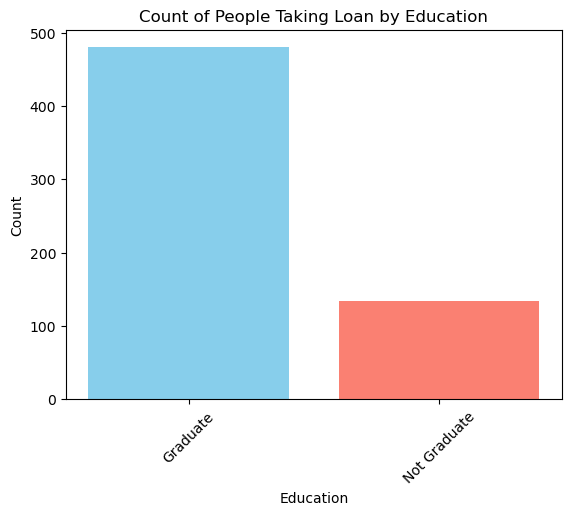

In [27]:
import matplotlib.pyplot as plt

# Number of people who take loan as group by Education
print("Number of people who take loan as group by Education")
print(data['Education'].value_counts())

# Define a color palette
colors = ['skyblue', 'salmon']

# Create a countplot with different colors for each bar
plt.bar(data['Education'].value_counts().index, data['Education'].value_counts(), color=colors)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Count of People Taking Loan by Education')

# Display the plot
plt.show()

# Splitting Dataset 

In [20]:
X = data.drop(['Loan_Status'],axis=1)
Y = data['Loan_Status']

In [21]:
#spliting train test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((429, 11), (185, 11), (429,), (185,))

In [22]:


X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
81,Male,Yes,1,Graduate,Yes,2395,0.0,146.412162,360.0,1.0,Semiurban
133,Male,Yes,0,Graduate,Yes,3459,0.0,25.000000,120.0,1.0,Semiurban
400,Male,Yes,2,Not Graduate,No,2889,0.0,45.000000,180.0,0.0,Urban
486,Male,No,2,Graduate,No,3547,0.0,80.000000,360.0,0.0,Rural
161,Male,Yes,0,Graduate,No,7933,0.0,275.000000,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
129,Male,Yes,0,Graduate,No,6080,2569.0,182.000000,360.0,1.0,Rural
144,Male,Yes,2,Graduate,No,11757,0.0,187.000000,180.0,1.0,Urban
72,Male,No,0,Graduate,No,3500,0.0,81.000000,300.0,1.0,Semiurban
235,Male,Yes,1,Graduate,No,5500,1260.0,170.000000,360.0,1.0,Rural


In [23]:
Y_train

81     Y
133    Y
400    N
486    N
161    N
      ..
129    N
144    Y
72     Y
235    Y
37     Y
Name: Loan_Status, Length: 429, dtype: object

In [24]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
533,Male,No,1,Graduate,No,11250,0.0,196.0,360.0,1.0,Semiurban
544,Female,Yes,0,Not Graduate,No,3017,663.0,102.0,360.0,1.0,Semiurban
41,Male,No,0,Graduate,No,1800,1213.0,47.0,360.0,1.0,Urban
148,Female,No,0,Graduate,No,10000,1666.0,225.0,360.0,1.0,Rural
111,Female,Yes,0,Graduate,No,2929,2333.0,139.0,360.0,1.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
180,Male,Yes,1,Graduate,No,6400,7250.0,180.0,360.0,0.0,Urban
491,Male,Yes,1,Not Graduate,No,5333,1131.0,186.0,360.0,1.0,Urban
42,Male,Yes,0,Graduate,No,2400,0.0,75.0,360.0,1.0,Urban
530,Male,Yes,0,Graduate,No,1025,5500.0,216.0,360.0,1.0,Rural


In [25]:
Y_test

533    N
544    Y
41     Y
148    N
111    Y
      ..
180    N
491    Y
42     Y
530    Y
457    N
Name: Loan_Status, Length: 185, dtype: object

## convert Categorical variable with Numerical values.

In [24]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [25]:
# Encoding categorical data
# Encoding the Independent Variable

columns = ['Gender','Married','Dependents','Education','Self_Employed']
labelencoder_X = LabelEncoder()
for i,col in enumerate(columns):
    
    X_train[col] = labelencoder_X.fit_transform(X_train.iloc[:,i])

X_train["Property_Area"] = labelencoder_X.fit_transform(X_train.iloc[:,10])

In [26]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_train = labelencoder_y.fit_transform(Y_train)

In [27]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
81,1,1,1,0,1,2395,0.0,146.412162,360.0,1.0,1
133,1,1,0,0,1,3459,0.0,25.000000,120.0,1.0,1
400,1,1,2,1,0,2889,0.0,45.000000,180.0,0.0,2
486,1,0,2,0,0,3547,0.0,80.000000,360.0,0.0,0
161,1,1,0,0,0,7933,0.0,275.000000,360.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
129,1,1,0,0,0,6080,2569.0,182.000000,360.0,1.0,0
144,1,1,2,0,0,11757,0.0,187.000000,180.0,1.0,2
72,1,0,0,0,0,3500,0.0,81.000000,300.0,1.0,1
235,1,1,1,0,0,5500,1260.0,170.000000,360.0,1.0,0


In [28]:
Y_train

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,

In [29]:
# Encoding categorical data (testing data)
# Encoding the Independent Variable

labelencoder_X = LabelEncoder()

for i,col in enumerate(columns):
    X_test[col] = labelencoder_X.fit_transform(X_test.iloc[:,i])

X_test["Property_Area"] = labelencoder_X.fit_transform(X_test.iloc[:,10])
    
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_test = labelencoder_y.fit_transform(Y_test)

In [30]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
533,1,0,1,0,0,11250,0.0,196.0,360.0,1.0,1
544,0,1,0,1,0,3017,663.0,102.0,360.0,1.0,1
41,1,0,0,0,0,1800,1213.0,47.0,360.0,1.0,2
148,0,0,0,0,0,10000,1666.0,225.0,360.0,1.0,0
111,0,1,0,0,0,2929,2333.0,139.0,360.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
180,1,1,1,0,0,6400,7250.0,180.0,360.0,0.0,2
491,1,1,1,1,0,5333,1131.0,186.0,360.0,1.0,2
42,1,1,0,0,0,2400,0.0,75.0,360.0,1.0,2
530,1,1,0,0,0,1025,5500.0,216.0,360.0,1.0,0


In [31]:
Y_test

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0])

In [32]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Model Training and Evaluation

In [33]:


def model_report(models,X_train,X_test,y_train,y_test):
    for name, model in models:
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)
        print("_"*80)
        print(f"Report For {name}".center(80))
        print()
        print(f"Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}")
        print(f"Test     Accuracy: {accuracy_score(y_test, y_hat_test):.2f}")
        print()
        #print(f"Training Accuracy: {confusion_matrix(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {confusion_matrix(y_test, y_hat_test)}")
        print()
        print(f"Training Accuracy: {classification_report(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {classification_report(y_test, y_hat_test)}")
        print('\n\n')

In [34]:
#Preparing different models
  
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
svc = SVC()
lc = LogisticRegression()
classifier = GaussianNB()
dt = DecisionTreeClassifier() 


model = [
    ('LogisticRegression',lc),
    ('KNeighborsClassifier',knn),
    ('svc',svc),
    ('RandomForestClassifier',rfc),
    ('GaussianNB',classifier),
    ('DecisionTreeClassifier',dt)
]

In [35]:
model_report(model,X_train,X_test,Y_train,Y_test)

________________________________________________________________________________
                         Report For LogisticRegression                          

Training Accuracy: 0.82
Test     Accuracy: 0.79

Test     Accuracy: [[ 25  36]
 [  2 122]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.92      0.45      0.61       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.86      0.72      0.74       429
weighted avg       0.84      0.82      0.80       429

Test     Accuracy:               precision    recall  f1-score   support

           0       0.93      0.41      0.57        61
           1       0.77      0.98      0.87       124

    accuracy                           0.79       185
   macro avg       0.85      0.70      0.72       185
weighted avg       0.82      0.79      0.77       185




__________________________________________________

## Model Optimization 

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
# dictionary with different parameters to test what is best for the model
param_grid = {
'n_estimators': [25, 50, 100, 150],
'max_features': ['sqrt', 'log2', None],
'max_depth': [3, 6, 9],
'max_leaf_nodes': [3, 6, 9],
}


forest = RandomForestClassifier(n_jobs=-1)

grid_search = GridSearchCV(forest, param_grid, cv=5,
                      scoring="accuracy", return_train_score=True)



In [38]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             return_train_score=True, scoring='accuracy')

In [39]:
best_model = grid_search.best_estimator_

In [40]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 100}


In [41]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 100}


In [42]:
result = grid_search.cv_results_

In [43]:
print(list(result.keys()))

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score']


In [44]:

train_scores = result['mean_train_score']
test_scores  = result['mean_test_score']
parameters = result['params']


scores = [ (tr, ts, pr) for tr, ts, pr in zip(train_scores, test_scores, parameters) ]


strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores):
    print(strformat.format(ix+1, tr, ts, pr, lb))
    



|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.8053512102515425 |  0.7972093023255814 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|2    | 0.8164299274527087 |  0.818139534883721  | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 50}|
______________________________________________________________________________________________________________

|3    | 0.8187622889687436 |  0.8134883720930233 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}|
______________________________________________________________________________________________________________

|4    | 0.818760593938572  |  0.818139534883721  | {'max_depth': 3, 'max_features': 's

In [45]:
scores.sort(key=lambda x: x[1],reverse=True)

print("Top 10 Models")
strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores[:10]):
    print(strformat.format(ix+1, tr, ts, pr, lb))
    

Top 10 Models
|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.8240067123194793 |  0.8204651162790698 | {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 9, 'n_estimators': 100}|
______________________________________________________________________________________________________________

|2    | 0.8251728930774969 |  0.8204651162790698 | {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|3    | 0.8240067123194793 |  0.8204651162790698 | {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 150}|
______________________________________________________________________________________________________________

|4    | 0.8210929554546071 |  0.8204651162790698 | {'max_depth': 6, 'ma

### Final best value

In [46]:
rfc = RandomForestClassifier(n_jobs=-1,max_depth= 3, max_features= 'sqrt', max_leaf_nodes= 9, n_estimators= 25)

In [47]:
model_report([("RandomForestClassifier",rfc)],X_train,X_test,Y_train,Y_test)

________________________________________________________________________________
                       Report For RandomForestClassifier                        

Training Accuracy: 0.83
Test     Accuracy: 0.79

Test     Accuracy: [[ 25  36]
 [  2 122]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.94      0.46      0.62       131
           1       0.81      0.99      0.89       298

    accuracy                           0.83       429
   macro avg       0.87      0.72      0.75       429
weighted avg       0.85      0.83      0.80       429

Test     Accuracy:               precision    recall  f1-score   support

           0       0.93      0.41      0.57        61
           1       0.77      0.98      0.87       124

    accuracy                           0.79       185
   macro avg       0.85      0.70      0.72       185
weighted avg       0.82      0.79      0.77       185




